Apply guided backprop on own model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model 
import wandb
input_path = "C:/DL_Lab/IDRID_dataset/images/train/IDRiD_006.jpg"
#input_path = "C:/DL_Lab/IDRID_dataset_orig/images/train/IDRiD_001.jpg"

(1, 224, 224, 3)

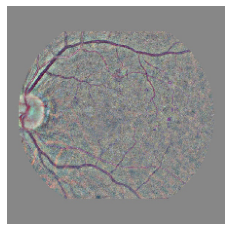

In [2]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = img_to_array(orig_image) # scales to 0-255
#image = preprocess_input(image) # only for resnet/vgg models
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image)
plt.axis("off")
image.shape

In [3]:
@tf.custom_gradient
def guided_RELU(x):
    # forward pass
    y = tf.nn.relu(x)
    # custom gradient: 
    def grad(dy):
        # is gradient > 0?
        grad_mask = tf.cast(dy > 0,"float32")
        # is fwd pass activation > 0
        act_mask = tf.cast(x > 0, "float32")
        return grad_mask * act_mask * dy
    return y, grad

In [4]:
model = wandb.restore('model.h5', run_path="stuttgartteam8/diabetic_retinopathy/24pjr9oi")
model = tf.keras.models.load_model('model.h5')


# pretrained model
#model = ResNet50(include_top=False, weights="imagenet")
#model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
model.summary()

Model: "multi_class_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)         

In [5]:
model.summary()

Model: "multi_class_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)         

In [6]:
#model2 = model.layers[:5]
# model2

In [7]:
#model2 = Model(inputs = [model.inputs], outputs = [model.get_layer('vgg16').get_layer('block5_conv3').output])
output = model.get_layer('vgg16').get_layer('block5_conv3').output
input = model.get_layer('vgg16').input
gb_model = Model(inputs=input, outputs=output)


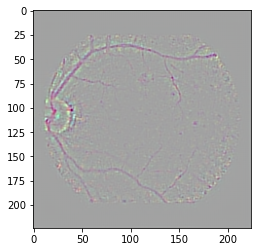

In [8]:
# go through all layers and replace relu with guided_relu
for layer in gb_model.layers:
    if hasattr(layer, "activation"):
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guided_RELU

# get access to individual gradients
with tf.GradientTape() as tape:
  inputs = tf.cast(image, tf.float32)
  # ensures that tensor is being traced by this tape
  tape.watch(inputs)
  outputs = gb_model(inputs)
# derive outputs by inputs
grads = tape.gradient(outputs, inputs)[0]

# scale to [0,1]
min = tf.math.reduce_min(grads)
max = tf.math.reduce_max(grads)
grads = (grads - min) / (max - min)
plt.imshow(grads)

(-0.5, 223.5, 223.5, -0.5)

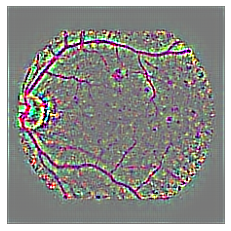

In [9]:
# this was copied from the keras repository, it enhances the picture
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


deprocess_image

plt.imshow(ups_grads_enh)
plt.axis("off")

In [10]:
model.predict(image)

array([[0.02512067, 0.0200627 , 0.22849354, 0.36089882, 0.36542434]],
      dtype=float32)